## Experiment to predict future citations based on the node embeddings (40_40)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Step 1: Load node embeddings
embeddings = {}
node_ids = []
with open("walks-vec-40.txt", "r") as f:
    for line in f:
        line = line.strip().split()
        node_id = line[0]
        node_ids.append(node_id)
        embedding = np.array(line[1:], dtype=np.float32)
        embeddings[node_id] = embedding

In [3]:
node_ids

['v1031',
 'v1055',
 'v1000',
 'v1284',
 'i165395',
 'i247408',
 'i238082',
 'i76913',
 'i250913',
 'i226929',
 'i133521',
 'i200018',
 'i149918',
 'i154989',
 'i116314',
 'i9527',
 'i202638',
 'i77065',
 'i95206',
 'i122188',
 'i157480',
 'i63564',
 'i138229',
 'i209007',
 'i138664',
 'i59794',
 'i139558',
 'i238189',
 'i26640',
 'i95398',
 'i63904',
 'i42745',
 'i9249',
 'i204688',
 'i20725',
 'i23635',
 'i133689',
 'i178903',
 'i32308',
 'i241977',
 'i148513',
 'i107571',
 'i95109',
 'i38075',
 'i9008',
 'i81697',
 'i116446',
 'i122084',
 'i186937',
 'i26139',
 'i64046',
 'i190945',
 'i105535',
 'i49765',
 'i169607',
 'i35115',
 'i234221',
 'i216876',
 'i116340',
 'i35222',
 'i133990',
 'i42426',
 'i182631',
 'i66722',
 'i57633',
 'i113856',
 'i65877',
 'i56913',
 'i23475',
 'i121725',
 'i17980',
 'i71744',
 'i230964',
 'i165240',
 'i111327',
 'i133462',
 'i51194',
 'i26405',
 'i30415',
 'i187155',
 'i138791',
 'i9566',
 'i216944',
 'i76628',
 'i155157',
 'i217487',
 'i233792',
 'i1

In [4]:
embeddings

{'v1031': array([ 2.640010e-01, -1.000687e+00,  5.057340e-01, -2.912070e-01,
        -2.251670e-01, -3.845810e-01, -4.399150e-01,  1.073268e+00,
         5.954060e-01, -3.787730e-01,  1.041216e+00, -7.712320e-01,
         3.622560e-01, -9.370000e-04, -3.063580e-01,  4.857270e-01,
        -6.962680e-01,  2.491420e-01,  9.042900e-02, -6.396240e-01,
        -8.112930e-01,  8.518980e-01, -5.230970e-01,  3.660300e-02,
         3.343290e-01, -5.655490e-01,  6.838840e-01,  6.607130e-01,
         1.539749e+00,  1.182477e+00,  7.983620e-01, -5.569130e-01,
         1.668000e-01, -1.721448e+00, -1.231220e-01, -1.257430e-01,
         1.266153e+00, -2.980280e-01,  5.638580e-01,  2.239640e-01,
         8.920630e-01, -3.761000e-03, -9.505100e-01,  1.003334e+00,
        -8.989920e-01,  2.675420e-01,  8.665490e-01, -8.130930e-01,
        -1.360380e-01, -1.695950e-01,  4.983370e-01, -7.920970e-01,
        -2.412440e-01,  6.994770e-01, -1.387927e+00, -7.361420e-01,
         6.173960e-01,  1.696920e-01,  

In [5]:
from py2neo import Graph
import pandas as pd
from numpy.random import randint

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.types import *
from pyspark.sql import functions as F

from sklearn.metrics import roc_curve, auc
from collections import Counter

from cycler import cycler
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [6]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", ""))

##### Cypher query to extract article nodes that have CITED relation between them and the published year <= 2006 and giving it a true(1) label 

In [7]:
train_existing_links = graph.run("""
MATCH (a1:Article)-[:CITED]->(a2:Article)
WHERE a1.year <= 2006
RETURN id(a1) AS node1, id(a2) AS node2, 1 AS label
""").to_data_frame()

In [8]:
len(train_existing_links)

182069

##### Cypher query to extract article nodes that have CITED relation between them and the published year > 2006 giving it a false(0) label 

In [9]:
train_missing_links = graph.run("""
MATCH (a1:Article)-[:CITED]->(a2:Article)
WHERE a1.year > 2006  
RETURN id(a1) AS node1, id(a2) AS node2, 0 AS label
""").to_data_frame()

In [10]:
len(train_missing_links)

107839

In [11]:
train_existing_links

node1   node2  label
0            0    1009      1
1            0    1008      1
2            0    1007      1
3            0    1006      1
4            0    1005      1
...        ...     ...    ...
182064  262687   52768      1
182065  262687  103620      1
182066  262687  193180      1
182067  262687   52769      1
182068  262687   27951      1

[182069 rows x 3 columns]

In [12]:
train_missing_links

node1   node2  label
0            1    1025      0
1            1    1024      0
2            1    1023      0
3            1    1022      0
4            1    1021      0
...        ...     ...    ...
107834  262739  264601      0
107835  262739  249680      0
107836  262739   54197      0
107837  262739  264604      0
107838  262739  264275      0

[107839 rows x 3 columns]

In [13]:
train_missing_links = train_missing_links.drop_duplicates()

In [14]:
len(train_missing_links)

107839

In [15]:
import pandas as pd

combined_links = pd.concat([train_existing_links, train_missing_links], ignore_index = True)

combined_links.drop_duplicates(subset=['node1', 'node2'], inplace = True)

combined_links.reset_index(drop=True, inplace=True)

In [16]:
len(combined_links)

289908

In [17]:
embeddings

{'v1031': array([ 2.640010e-01, -1.000687e+00,  5.057340e-01, -2.912070e-01,
        -2.251670e-01, -3.845810e-01, -4.399150e-01,  1.073268e+00,
         5.954060e-01, -3.787730e-01,  1.041216e+00, -7.712320e-01,
         3.622560e-01, -9.370000e-04, -3.063580e-01,  4.857270e-01,
        -6.962680e-01,  2.491420e-01,  9.042900e-02, -6.396240e-01,
        -8.112930e-01,  8.518980e-01, -5.230970e-01,  3.660300e-02,
         3.343290e-01, -5.655490e-01,  6.838840e-01,  6.607130e-01,
         1.539749e+00,  1.182477e+00,  7.983620e-01, -5.569130e-01,
         1.668000e-01, -1.721448e+00, -1.231220e-01, -1.257430e-01,
         1.266153e+00, -2.980280e-01,  5.638580e-01,  2.239640e-01,
         8.920630e-01, -3.761000e-03, -9.505100e-01,  1.003334e+00,
        -8.989920e-01,  2.675420e-01,  8.665490e-01, -8.130930e-01,
        -1.360380e-01, -1.695950e-01,  4.983370e-01, -7.920970e-01,
        -2.412440e-01,  6.994770e-01, -1.387927e+00, -7.361420e-01,
         6.173960e-01,  1.696920e-01,  

In [18]:
new_embeddings = {key[1:]: value for key, value in embeddings.items()}
new_embeddings

{'1031': array([ 2.640010e-01, -1.000687e+00,  5.057340e-01, -2.912070e-01,
        -2.251670e-01, -3.845810e-01, -4.399150e-01,  1.073268e+00,
         5.954060e-01, -3.787730e-01,  1.041216e+00, -7.712320e-01,
         3.622560e-01, -9.370000e-04, -3.063580e-01,  4.857270e-01,
        -6.962680e-01,  2.491420e-01,  9.042900e-02, -6.396240e-01,
        -8.112930e-01,  8.518980e-01, -5.230970e-01,  3.660300e-02,
         3.343290e-01, -5.655490e-01,  6.838840e-01,  6.607130e-01,
         1.539749e+00,  1.182477e+00,  7.983620e-01, -5.569130e-01,
         1.668000e-01, -1.721448e+00, -1.231220e-01, -1.257430e-01,
         1.266153e+00, -2.980280e-01,  5.638580e-01,  2.239640e-01,
         8.920630e-01, -3.761000e-03, -9.505100e-01,  1.003334e+00,
        -8.989920e-01,  2.675420e-01,  8.665490e-01, -8.130930e-01,
        -1.360380e-01, -1.695950e-01,  4.983370e-01, -7.920970e-01,
        -2.412440e-01,  6.994770e-01, -1.387927e+00, -7.361420e-01,
         6.173960e-01,  1.696920e-01,  2

In [19]:
new_node_ids = [node_id[1:] for node_id in node_ids]
new_node_ids

['1031',
 '1055',
 '1000',
 '1284',
 '165395',
 '247408',
 '238082',
 '76913',
 '250913',
 '226929',
 '133521',
 '200018',
 '149918',
 '154989',
 '116314',
 '9527',
 '202638',
 '77065',
 '95206',
 '122188',
 '157480',
 '63564',
 '138229',
 '209007',
 '138664',
 '59794',
 '139558',
 '238189',
 '26640',
 '95398',
 '63904',
 '42745',
 '9249',
 '204688',
 '20725',
 '23635',
 '133689',
 '178903',
 '32308',
 '241977',
 '148513',
 '107571',
 '95109',
 '38075',
 '9008',
 '81697',
 '116446',
 '122084',
 '186937',
 '26139',
 '64046',
 '190945',
 '105535',
 '49765',
 '169607',
 '35115',
 '234221',
 '216876',
 '116340',
 '35222',
 '133990',
 '42426',
 '182631',
 '66722',
 '57633',
 '113856',
 '65877',
 '56913',
 '23475',
 '121725',
 '17980',
 '71744',
 '230964',
 '165240',
 '111327',
 '133462',
 '51194',
 '26405',
 '30415',
 '187155',
 '138791',
 '9566',
 '216944',
 '76628',
 '155157',
 '217487',
 '233792',
 '149649',
 '121728',
 '121911',
 '88774',
 '160648',
 '133811',
 '41738',
 '213138',
 '642

In [20]:
import numpy as np

# List to store the extracted embeddings
node_con_embeddings = []
labels = []
linkCount = 0
listNoLinkCount = 0
noLinkCount = 0
# Iterate over the rows of the combined_existing_links DataFrame
for index, row in train_existing_links.iterrows():
    node1_id = str(row['node1'])
    node2_id = str(row['node2'])
    label = row['label']
    
    # Check if the node IDs exist in the embeddings dictionary
    if node1_id in new_node_ids and node2_id in new_node_ids and label == 1:
        node1_embedding = new_embeddings[node1_id]
        node2_embedding = new_embeddings[node2_id]
        
        # Append the embeddings to the node_embeddings list
        node_con_embeddings.append(np.concatenate((node1_embedding, node2_embedding)))
        labels.append(label)
        linkCount = linkCount + 1               

# Convert the node_embeddings list to a numpy array
node_con_embeddings = np.array(node_con_embeddings)
labels = np.array(labels)
print(linkCount)

182069


#### The above code implies that we have 182069 node embeddings that represent connected nodes (label = 1)

In [21]:
train_missing_links

node1   node2  label
0            1    1025      0
1            1    1024      0
2            1    1023      0
3            1    1022      0
4            1    1021      0
...        ...     ...    ...
107834  262739  264601      0
107835  262739  249680      0
107836  262739   54197      0
107837  262739  264604      0
107838  262739  264275      0

[107839 rows x 3 columns]

In [22]:
len(train_missing_links)

107839

In [22]:
import numpy as np

# List to store the extracted embeddings
node_negative_embeddings = []
labels_negative = []
noLinkCount = 0
# Iterate over the rows of the combined_existing_links DataFrame
for index, row in train_missing_links.iterrows():
    node1_id = str(row['node1'])
    node2_id = str(row['node2'])
    label = row['label']
    
    # Check if the node IDs exist in the embeddings dictionary
    if node1_id in new_node_ids and node2_id in new_node_ids and label == 0:
        node1_embedding = new_embeddings[node1_id]
        node2_embedding = new_embeddings[node2_id]
        # Append the embeddings to the node_embeddings list
        node_negative_embeddings.append(np.concatenate((node1_embedding, node2_embedding)))
        labels_negative.append(label)
        noLinkCount = noLinkCount + 1                

# Convert the node_embeddings list to a numpy array
node_negative_embeddings = np.array(node_negative_embeddings)
labels_negative = np.array(labels_negative)
print(noLinkCount)

107838


In [23]:
len(labels_negative)

107838

In [24]:
len(labels_negative)

107838

In [25]:
# Convert the labels list to a numpy array
labels_negative = np.array(labels_negative)

# Reshape the labels array to a 2D array with shape (n_samples, 1)
labels_negative = labels_negative.reshape(-1, 1)

# Concatenate the embeddings and labels along the second axis
data = np.concatenate((node_negative_embeddings, labels_negative), axis=1)

# Shuffle the data
np.random.shuffle(data)

# Split the shuffled data back into embeddings and labels
node_negative_embeddings_shuffled = data[:, :-1]
labels_negative_shuffled = data[:, -1]

# Convert the shuffled arrays back to numpy arrays
node_negative_embeddings_shuffled = np.array(node_negative_embeddings_shuffled)
labels_negative_shuffled = np.array(labels_negative_shuffled)


In [26]:
len(node_negative_embeddings_shuffled)

107838

The above code indicates that we have 93274 node embeddings which have no links between them (label=0)

In [27]:
print(len(node_con_embeddings))
print(len(labels))
print(len(node_negative_embeddings_shuffled))
print(len(labels_negative_shuffled))

182069
182069
107838
107838


In [28]:
# Convert node_negative_embeddings to a numpy array
node_negative_embeddings = np.array(node_negative_embeddings)

In [29]:
# Combine the positive and negative samples
balanced_node_embeddings = np.concatenate((node_negative_embeddings, node_con_embeddings), axis=0)

In [30]:
len(balanced_node_embeddings)

289907

In [31]:
balanced_labels = np.concatenate((labels_negative_shuffled, labels), axis = 0)

In [32]:
len(balanced_labels)

289907

In [33]:
# Shuffle the data while maintaining correspondence
permutation = np.random.permutation(len(balanced_node_embeddings))
balanced_node_embeddings = balanced_node_embeddings[permutation]
balanced_labels = balanced_labels[permutation]

In [34]:
len(balanced_node_embeddings)

289907

### Model Training

Accuracy: 0.9224759408092167
Precision: 0.9230240731443068
Recall: 0.9566717791411042
F1 Score: 0.9395467688790262
ROC AUC Score: 0.9104970446706918


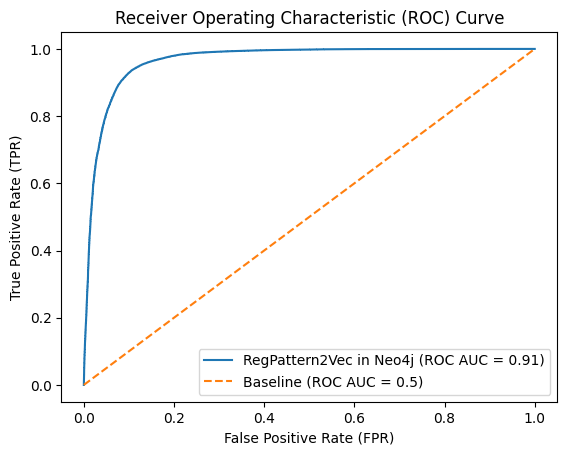

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(balanced_node_embeddings, balanced_labels, test_size=0.2, random_state=42)

model = LogisticRegression(solver='liblinear')

model.fit(X_train, y_train)

# Predict the probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Predict the labels for the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate baseline FPR and TPR
baseline_fpr = np.linspace(0, 1, 100)
baseline_tpr = baseline_fpr  # TPR = FPR for the baseline curve

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='RegPattern2Vec in Neo4j (ROC AUC = {:.2f})'.format(roc_auc))
plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline (ROC AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [36]:
node_ids = ['2002', '1026']
node1_id, node2_id = node_ids[0], node_ids[1]

node1_embedding_run = new_embeddings[node1_id]
node2_embedding_run = new_embeddings[node2_id]

In [37]:
node_embeddings = np.concatenate([node1_embedding_run, node2_embedding_run])
node_embeddings = node_embeddings.reshape(1,-1)
prediction = model.predict(node_embeddings)

# Interpret the prediction
if prediction == 1:
    print("There is a high likelihood of a future citation between the two nodes.")
else:
    print("There is a low likelihood of a future citation between the two nodes.")

There is a low likelihood of a future citation between the two nodes.
